# 第19章 类型参数化
在本章，我们将介绍Scala类型参数化的细节。在这个过程中我们将通过一个具体的例子来展示第13章介绍过的信息隐藏的技巧：设计一个纯函数式的类。我们将一起呈现类型参数化和信息隐藏，因为信息隐藏可以被用于更通用的类型参数化型变注解。

类型参数化让我们能够编写泛型的类和特质。例如，集（set）是泛型的，接收一个类型参数：定义为Set[T]。这样，具体的集的实例可以是 Set[String]、Set[Int]等，不过它必须是某种类型的集。与Java不同，Scala并不允许原生类型，Scala要求我们给出类型参数。型变定义了参数化类型的继承关系，以Set[String]为例，型变定义了它是不是Set[AnyRef]的子类型。

本章包含三个部分。在第一部分中我们将开发一个表示纯函数式队列的数据结构。第二部分介绍将这个结构的内部表现细节隐藏起来的技巧。最后一个部分介绍类型参数的型变以及它跟信息隐藏的关系。

## 19.1 函数式队列
函数式队列是一个数据结构，它支持三种操作：
head 返回队列的第一个元素  
tail 返回除第一个元素外的队列  
enqueue 返回一个将给定元素追加到队尾的新队列

跟可变队列不同，函数式队列在新元素被追加时，其内容并不改变，而是会返回一个新的包含该元素的队列。本章的目标是创建一个名为Queue的类，使用起来的效果如下：  
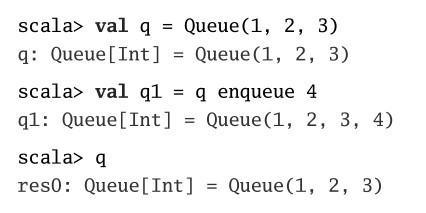  
如果Queue的实现是可变的，那么上述代码的第二步enqueue操作会影响q的内容。事实上，在操作过后，结果队列q1和原始队列q都将包含序列1,2,3,4。不过对于函数式队列而言，被追加的值只会出现在结果q1中，而不会出现在被执行该操作的队列q中。

纯函数式队列还跟列表有一些相似，它们都被称作完全持久化（fully persistent）的数据结构，在经过扩展或修改之后，老版本将继续保持可用。它们都支持head和tail操作。不过列表通常用：：操作在头部扩展，而队列在尾部扩展，用的是enqueue方法。

如何实现才是高效的呢？最理想的情况下，一个函数式（不可变）的队列跟一个指令式（可变）的队列相比不应该有从根本上更高的额外开销。也就是说，所有三个操作，head、tail和enqueue操作都应该以常量时间完成。

实现函数式队列的一种简单方式是用列表来作为表现类型。这样一来head和tail都只是简单地翻译成列表中相同的操作，而enqueue则通过列表拼接来实现。

这让我们得到下面的实现：

In [6]:
class SlowAppendQueue[T](elems: List[T]){//不高效
    def head = elems.head
    def tail = new SlowAppendQueue(elems.tail)
    def enqueue(x: T) = new SlowAppendQueue(elems ::: List(x))
}

defined class SlowAppendQueue

这个实现的问题出在enqueue操作上。它的时间开销跟队列中存放的元素数量成正比。如果想要常量时间的追加操作，可以尝试将底层列表中的元素顺序反转过来，这样最后追加的元素出现在列表的头部。这让我们得到下面的实现：

In [5]:
class SlowHeadQueue[T](smele: List[T]){//不高效
    def head = smele.last
    def tail = new SlowAppendQueue(smele.init)
    def enqueue(x: T) = new SlowHeadQueue(x :: smele)
}

defined class SlowHeadQueue

现在enqueue是常量时间了，但head和tail并不是。它们现在的时间开销跟队列中元素数量成正比了。

从这两个例子看，似乎并没有一个实现可以对所有三种操作都做到常量时间。事实上，这看上去几乎是不可能做到的。不过，将两种操作结合到一起，可以非常接近这 个目标。背后的理念是用leading和trailing两个列表来表示队列。leading列表包含队列中靠前的元素，而trailing列表包含队列中靠后的元素，按倒序排列。整个队列在任何时刻的内容都等于“leading :::trailing.reverse”。

现在，要追加一个元素，只需要用：：操作符将它追加到trailing，这样一来enqueue就是常量时间。这意味着，当一开始为空的队列通过接连的 enqueue操作初始化时，trailing列表会增长而leading会保持空的状态。接下来，在首次head或tail被执行到空的leading 列表之前，整个trailing列表被复制到leading，同时元素的顺序被反转。这是通过一个名为mirror的操作完成的。

示例19.1给出了使用该实现方案的队列。

In [4]:
  class Queue[T](
    private val leading: List[T], 
    private val trailing: List[T] 
  ) {
    private def mirror = 
      if (leading.isEmpty)
        new Queue(trailing.reverse, Nil)
      else
        this
  
    def head = mirror.leading.head
  
    def tail = { 
      val q = mirror 
      new Queue(q.leading.tail, q.trailing) 
    }
  
    def enqueue(x: T) = 
      new Queue(leading, x :: trailing)
      
    override def toString = 
      leading ::: trailing.reverse mkString ("Queue(", ", ", ")")
  }




defined class Queue

In [7]:
val q = new Queue[Int](List(1, 2), List(3, 4))
println(q)
println(q.head)
println(q.tail)

val q1 = q enqueue 5

Queue(1, 2, 4, 3)
1
Queue(2, 4, 3)


q: Queue[Int] = Queue(1, 2, 4, 3)
q1: Queue[Int] = Queue(1, 2, 4, 3, 5)

这个队列实现的复杂度如何呢？mirror操作的耗时跟队列元素的数量成正比，但仅当leading为空时才发生。如果leading为非空，那么它就直接 返回了。由于head和tail调用了mirror，它们的复杂度与队列长度也成线性关系。不过，随着队列变长，mirror被调用的频率也会变低。

的确，假定我们有一个长度为n的队列，其leading列表为空。那么mirror操作必须将一个长度为n的列表做一次反向拷贝。不过下一次mirror要 做任何工作都要等到leading列表再次变空时，这将发生在n次tail操作过后。这意味着可以让这n次tail操作“分担”1/n的mirror复杂 度，也就是常量时间的工作。假定head、tail和enqueue操作差不多以相同频次出现，那么摊销（amortized）复杂度对于每个操作而言就是常量的了。因此从渐进的视角看，函数式队列跟可变队列同样高效。

不过，对于这个论点，我们要附加两点说明。首先，这里探讨的只是渐进行为，常量因子可能会不一样。其次，这个论点基于head、tail和enqueue的调用频次差不多相同。如果head的调用比其他两个操作要频繁得多，那么这个论点就不成立，因为每次对head的调用都将牵涉用mirror重新组织列表这个昂贵的操作。第二点可以被避免，可以设计出这样一个函数式队列，在连续的head操作中，只有第一次需要重组。可以在本章末尾找到相关例子（示例 19.10）。

## 19.2 信息隐藏
示例19.1给出的Queue实现在效率上来说已经非常棒了。你可能会表示反对，因为为了达到这个效率，我们暴露了不必要的实现细节。全局可访问的 Queue构造方法接收两个列表作为参数，其中一个顺序还是反的：很难说这是一个直观的对队列的表示。我们需要对使用方代码隐藏这个构造方法。在本节，我们将展示在Scala中完成这个动作的几种方式。

### 私有构造方法和工厂方法

在Java中，我们可以通过标记为private来隐藏构造方法。在Scala中，主构造方法并没有显式的定义，它是通过类参数和类定义体隐式地定义的。尽管如此，还是可以通过在参数列表前加上private修饰符来隐藏主构造方法，如示例19.2所示：  

In [10]:
  class Queue[T] private ( //注意这里括号前的private
    private val leading: List[T],
    private val trailing: List[T]
  ) 
  {
    private def mirror = 
      if (leading.isEmpty) new Queue(trailing.reverse, Nil)
      else this
    def head = 
      mirror.leading.head
    def tail = { 
      val q = mirror; 
      new Queue(q.leading.tail, q.trailing) 
    }
    def append(x: T) = 
      new Queue(leading, x :: trailing)

    override def toString() =
      (leading ::: trailing.reverse) mkString ("Queue(", ", ", ")")
  }

defined class Queue

<center>示例19.2 通过标记为私有来隐藏主构造方法</center>  

**类名和参数之间的private修饰符表示Queue的构造方法是私有的**：它只能从类本身及其伴生对象访问。类名Queue依然是公有的，因此可以把它当作类型来使用，但不能调用其构造方法：  
```scala
val q = new Queue[Int](List(1, 2), List(3, 4))

cmd9.sc:1: constructor Queue in class Queue cannot be accessed in class Helper
val q = new Queue[Int](List(1, 2), List(3, 4))
        ^Compilation Failed

Compilation Failed
```
 

既然Queue类的主构造方法不能从使用方代码调用，我们需要别的方式来创建新的队列。一种可能的方式是添加一个**辅助构造方法**，就像这样：  

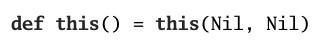  

前一例中给出的辅助构造方法构建一个空的队列。我们可以再提炼一下，让辅助构造方法接收一组初始队列元素：  

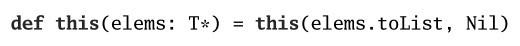  

回忆一下，**T\*用来表示重复的参数**（参考8.8节）。
另一种可能是添加一个工厂方法来从这样一组初始元素来构建队列。一种不错的实现方式是定义一个跟Queue类同名的对象，并提供一个apply方法，如示例19.3所示：  

In [12]:
  class Queue[T] private ( //注意这里括号前的private
    private val leading: List[T],
    private val trailing: List[T]
  ) 
  {
    private def mirror = 
      if (leading.isEmpty) new Queue(trailing.reverse, Nil)
      else this
    def head = 
      mirror.leading.head
    def tail = { 
      val q = mirror; 
      new Queue(q.leading.tail, q.trailing) 
    }
    def append(x: T) = 
      new Queue(leading, x :: trailing)

    override def toString() =
      (leading ::: trailing.reverse) mkString ("Queue(", ", ", ")")
  }

  object Queue {
    // constructs a queue with initial elements `xs'
    def apply[T](xs: T*) = new Queue[T](xs.toList, Nil)
  }

defined class Queue
defined object Queue

<center>示例19.3 伴生对象中的apply工厂方法</center>

通过将这个对象跟Queue类放在同一个源文件中，我们就让对象成为了Queue类的伴生对象。在13.5节你曾看到伴生对象拥有与对应伴生类相同的访问权限。因此，Queue对象的apply方法可以创建一个新的Queue，尽管Queue类的构造方法是私有的。

注意，由于这个工厂方法的名称是apply，使用方代码可以用诸如Queue（1, 2, 3）这样的表达式来创建队列。这个表达式会展开成Queue. apply（1, 2, 3），因为Queue是对象而不是函数。这样一来，Queue在使用方看来，就像是全局定义的工厂方法一样。实际上，Scala并没有全局可见的方法，每个方法都必须被包含在某个对象或某个类当中。不过，通过在全局对象中使用名为apply的方法，可以支持看上去像是全局方法的使用模式。

### 备选方案：私有类

私有构造方法和私有成员只是隐藏类的初始化和内部表现形式的一种方式。另一种更激进的方式是隐藏类本身，并且只暴露一个反映类的公有接口的特质。

示例19.4的代码实现了这样一种设计。其中定义了一个Queue特质，声明了方法head、tail和enqueue。所有这三个方法都实现在子类 QueueImpl中，这个子类本身是对象Queue的一个private的内部类。这种做法暴露给使用方的信息跟之前一样，不过采用了不同的技巧。跟之 前逐个隐藏构造方法和成员方法不同，这个版本隐藏了整个实现类。

In [14]:
  trait Queue[T] {
    def head: T
    def tail: Queue[T]
    def enqueue(x: T): Queue[T]
  }
  
  object Queue {
  
    def apply[T](xs: T*): Queue[T] = 
      new QueueImpl[T](xs.toList, Nil)
  
    private class QueueImpl[T](//注意这里private写在calss前面,只继承了Queue特质
      private val leading: List[T],
      private val trailing: List[T]
    ) extends Queue[T] {
  
      def mirror = 
        if (leading.isEmpty)
          new QueueImpl(trailing.reverse, Nil)
        else 
          this
  
      def head: T = mirror.leading.head
  
      def tail: QueueImpl[T] = {
        val q = mirror
        new QueueImpl(q.leading.tail, q.trailing)
      }
  
      def enqueue(x: T) = 
        new QueueImpl(leading, x :: trailing)
    override def toString() =
        (leading ::: trailing.reverse) mkString ("Queue(", ", ", ")")
    }
  }

defined trait Queue
defined object Queue

In [15]:
val q = Queue[Int]() enqueue 1 enqueue 2
println(q)

Queue(1, 2)


q: Queue[Int] = Queue(1, 2)

<center>示例19.4 函数式队列的类型抽象</center>

## 19.3 型变注解
示例19.4定义的Queue是一个特质，而不是一个类型。Queue不是类型，因为它接收一个类型参数。
因此，我们并不能创建类型为Queue的变量：